# Linear Regression and Univariate Time-Series Analysis (Using ARMA)

This notebook implements linear regression for forecasting and analysis. Linear regression is a basic econometric tool, and is the starting point for a variety of prediction models such as ARMA and non-linear algorithms. It will also implement the SARIMAX, a modified ARMA forecasting model. The exogenous variables, which improve model forecasts, will be indicated.

For the analysis, I am utilizing the historical JP Morgan and S&P prices (downloaded from Yahoo Finance) with the following characteristics:

- Period: February 1, 2018 – December 30, 2018
- Frequency: Daily
- Price considered in the analysis: Close price adjusted for dividends and splits

In [4]:
import datetime
import itertools
import time

import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import statsmodels.api as sm
import yfinance as yf

JPM avg stock value = $104.58
JPM annualized volatility = 22.89%
JPM avg daily return = -0.07%

S&P500 avg value = 2743.26
S&P500 annualized volatility = 17.66%
S&P500 avg daily return = -0.06%


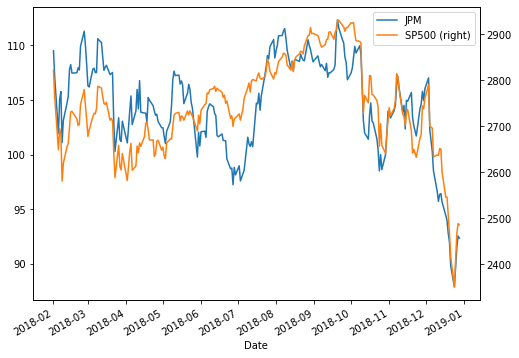

In [5]:
# Download data from Yahoo Finance: JPMC adjusted stock price and S&P 500 index
df_jpm = yf.download("JPM", start='2018-02-01', end='2018-12-30', progress=False)
df_sp500 = yf.download("^GSPC", start='2018-02-01', end='2018-12-30', progress=False)

# Assemble data and compute daily return
df = pd.DataFrame({
    'JPM': df_jpm['Adj Close'],
    'SP500': df_sp500['Adj Close']
})
df['JPM_Ret'] = np.log(df['JPM']/df['JPM'].shift(1))
df['SP500_Ret'] = np.log(df['SP500']/df['SP500'].shift(1))

print('JPM avg stock value = ${:.2f}'.format(df['JPM'].mean()))
print('JPM annualized volatility = {:.2f}%'.format(df['JPM_Ret'].std() * np.sqrt(252) * 100))
print('JPM avg daily return = {:.2f}%'.format(df['JPM_Ret'].mean() * 100))
print('')
print('S&P500 avg value = {:.2f}'.format(df['SP500'].mean()))
print('S&P500 annualized volatility = {:.2f}%'.format(df['SP500_Ret'].std() * np.sqrt(252) * 100))
print('S&P500 avg daily return = {:.2f}%'.format(df['SP500_Ret'].mean() * 100))

df[["JPM", "SP500"]].plot(secondary_y=["SP500"], figsize=(8,6))

In [6]:
# Examine data
df

,JPM,SP500,JPM_Ret,SP500_Ret
Date,,,,
2018-02-01,109.521912,2821.979980,NaN,NaN
2018-02-02,107.094742,2762.129883,-0.022411,-0.021437
2018-02-05,101.959282,2648.939941,-0.049140,-0.041843
2018-02-06,105.061180,2695.139893,0.029969,0.017291
2018-02-07,105.773392,2681.659912,0.006756,-0.005014
...,...,...,...,...
2018-12-21,89.803154,2416.620117,-0.023923,-0.020803
2018-12-24,87.867294,2351.100098,-0.021792,-0.027487
2018-12-26,91.510139,2467.699951,0.040622,0.048403


## Linear Regression

The two variable regression is implemented to predict JP Morgan stock return using S&P500 index return as an independent
variable.

In [9]:
# Linear regression using statsmodel for JPM price ~ SP500 index
model = sm.OLS(df.dropna()["JPM_Ret"], sm.add_constant(df.dropna()["SP500_Ret"]))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                JPM_Ret   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     340.5
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           5.40e-47
Time:                        17:17:41   Log-Likelihood:                 748.30
No. Observations:                 228   AIC:                            -1493.
Df Residuals:                     226   BIC:                            -1486.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.313      0.755      -0.001       0.001
SP500_Ret      1.0046      0.054     18.454      0.000       0.897       1.112
==============================================================================
Omnibus:                       22.044   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.785
Skew:                           0.378   Prob(JB):                     2.83e-13
Kurtosis:                       5.348   Cond. No.                         90.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared measure is not very close to 1 but suggests that the linear regression model explained much of the variation between the two returns. The F-statistic shows a very low probability, which is a strong signal that the coefficients are not zero or in other words, the linear model is a good fit.

## Univariate Time Series

The S&P Case Shiller Index is a composite measure that on a monthly basis calculates house price indices
based on 20 cities across the United States.

Downloadinging the following data:
- Datasource: https://fred.stlouisfed.org/series/CSUSHPISA
- Period considered in the analysis: January 1987 – latest data
- Frequency: monthly data

Then:
1. Forecasting S&P/Case-Shiller U.S. National Home Price Index using an ARMA model.
2. Implementing the Augmented Dickey-Fuller Test for checking the existence of a unit root in Case-Shiller Index series.
3. Implementing an ARIMA(p,d,q) model. Determining p, d, q using Information Criterion or Box-Jenkins methodology.
4. Forecasting the future evolution of Case-Shiller Index using the ARMA model. Testing the model using in-sample forecasts.

In [ ]:
HPI_URL = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id=CSUSHPISA&cosd=1987-01-01&coed=2020-03-01'
hpi_df = pd.read_csv(HPI_URL, header=0, index_col=0, parse_dates=True)

In [ ]:
# Examine the download
hpi_df

,CSUSHPISA
DATE,
1987-01-01,63.988
1987-02-01,64.447
1987-03-01,64.761
1987-04-01,65.154
1987-05-01,65.584
...,...
2019-11-01,212.663
2019-12-01,213.601
2020-01-01,214.560


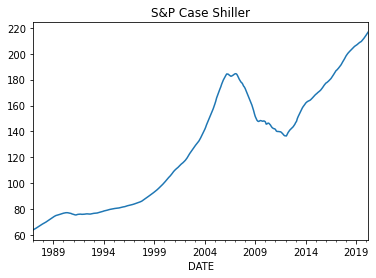

In [ ]:
# Plot the HPI and show the tread
hpi_df["CSUSHPISA"].plot(title='S&P Case Shiller')

The global financial crisis-fueled decrease in the index value between 2008-2012 is the most
prominent feature.

In [ ]:
# Confirm trend with ADF test
adf, pvalue, used_lag, num_obs, critical, icbest = sm.tsa.adfuller(hpi_df["CSUSHPISA"], 1)
print('ADF Statistic: {:.4f}'.format(adf))
print('p-value: {:.4f}, hypothesis of unit root {} rejected'.format(pvalue, "is not" if pvalue > 0.05 else "is"))
print('Critical Values:')
for key, value in critical.items():
    print("{:>6s}: {:.4f}".format(key, value))

ADF Statistic: -0.1925
p-value: 0.9394, hypothesis of unit root is not rejected
Critical Values:
    1%: -3.4469
    5%: -2.8688
   10%: -2.5707


In order to make sure the trend has stationarity, i.e. constant mean and no seasonality, the Augmented
Dickey-Fuller test (ADF) is performed. It turns out the ADF statistic in this case is −0.1925 with a p-value
of 0.9394. Since the p-value is greater than 0.05, the null hypothesis is accepted and it is concluded that the unit
root is present. In other words, the trend is not stationary.

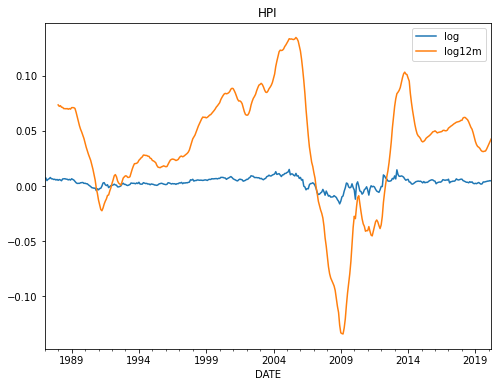

In [ ]:
# transform time series to stationary one
# by first order difference, log, diff of log of 12 mon lag, diff of diff
hpi_diff = pd.DataFrame({
    "HPI": hpi_df["CSUSHPISA"],
    "diff": hpi_df["CSUSHPISA"].diff(periods=1),
    "log": np.log(hpi_df["CSUSHPISA"]/hpi_df["CSUSHPISA"].shift(1)),
    "log12m": np.log(hpi_df["CSUSHPISA"]/hpi_df["CSUSHPISA"].shift(12))
})

# Plot to visually confirm stationary
#hpi_diff["log12mdiff"] = hpi_diff["log12m"].diff(periods=1)
hpi_diff[["log", "log12m"]].plot(title="HPI", figsize=(8,6))

In [ ]:
# Confirm we have a stationary time series by running ADF test on each columns:
stationary = []
for colname in hpi_diff.columns:        
    adf, pvalue, used_lag, num_obs, critical, icbest = sm.tsa.adfuller(hpi_diff[colname].dropna(), 1)
    print('Column: {}'.format(colname))
    print('  ADF Statistic: {:.4f}'.format(adf))
    if pvalue > 0.05:
        verdict = "is not"
    else:
        verdict = "is"
        stationary.append(colname)
    print('  p-value: {:.4g}, hypothesis of unit root {} rejected'.format(pvalue, verdict))
    print('  Critical Values:')
    for key, value in critical.items():
        print("{:>8s}: {:.4f}".format(key, value))
print()
print("Stationary time series: {}".format(", ".join(stationary)))

Column: HPI
  ADF Statistic: -0.1925
  p-value: 0.9394, hypothesis of unit root is not rejected
  Critical Values:
      1%: -3.4469
      5%: -2.8688
     10%: -2.5707
Column: diff
  ADF Statistic: -3.4353
  p-value: 0.009814, hypothesis of unit root is rejected
  Critical Values:
      1%: -3.4469
      5%: -2.8688
     10%: -2.5707
Column: log
  ADF Statistic: -3.6056
  p-value: 0.005656, hypothesis of unit root is rejected
  Critical Values:
      1%: -3.4469
      5%: -2.8688
     10%: -2.5707
Column: log12m
  ADF Statistic: -3.1066
  p-value: 0.02607, hypothesis of unit root is rejected
  Critical Values:
      1%: -3.4474
      5%: -2.8691
     10%: -2.5708

Stationary time series: diff, log, log12m


To transform the given time series into a stationary one, several new time series are generated: the first order difference, the logarithmic return (first order difference in log scale of the
index), and the 12-month logarithmic return (12-month lag difference in log scale of the index). All these
derived time series are stationary according to ADF test.

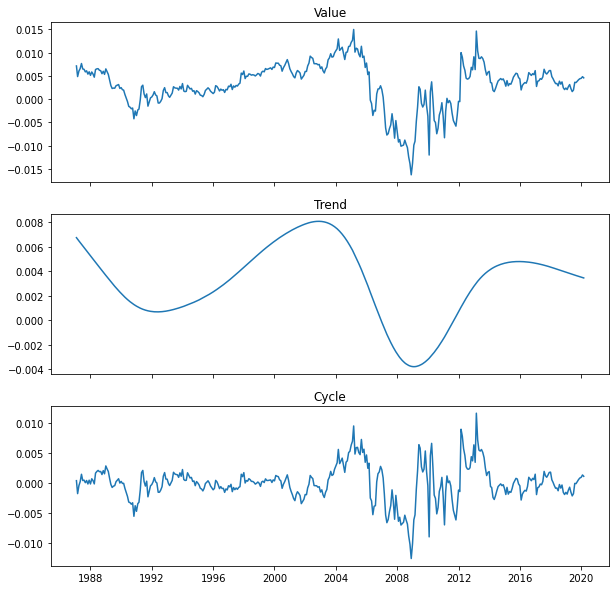

In [ ]:
# Run Hodrick-Prescott filter to estimate cycle and trends from data, using smoothing param suggested
# by https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html
colname = "log"
cycle, trend = sm.tsa.filters.hpfilter(hpi_diff[colname].dropna(), 129600)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,10))
ax[0].plot(hpi_diff[colname].dropna())
ax[0].set_title('Value')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

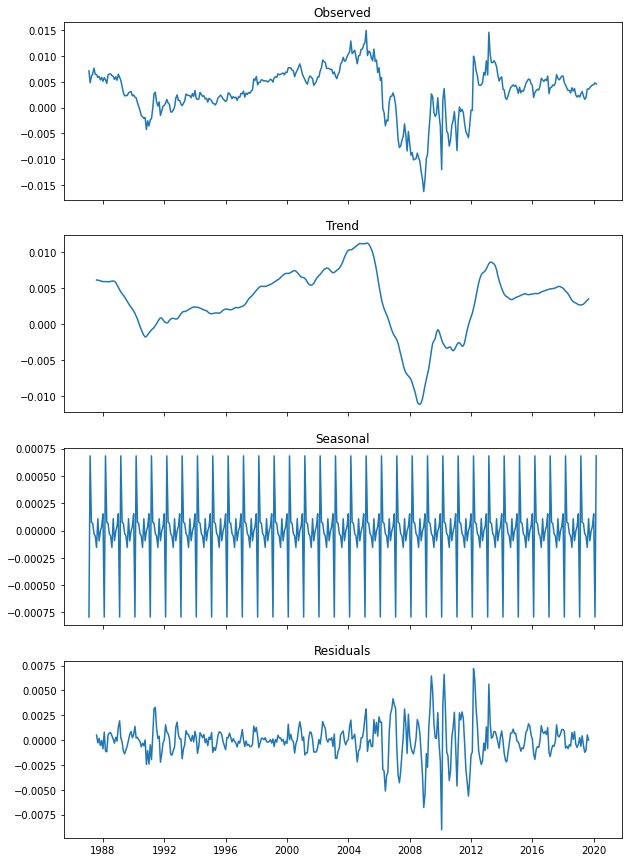

In [ ]:
# Check for seasonal fluctuations
decompose = sm.tsa.seasonal_decompose(hpi_diff[colname].dropna(), 'additive')

fig, ax = plt.subplots(4,1, sharex=True, figsize=(10,15))
ax[0].plot(decompose.observed)
ax[0].set_title('Observed')
ax[1].plot(decompose.trend)
ax[1].set_title('Trend')
ax[2].plot(decompose.seasonal)
ax[2].set_title('Seasonal')
ax[3].plot(decompose.resid)
ax[3].set_title('Residuals')
plt.show()

The Hodrick-Prescott filter detects cycles and trends in the data. The seasonailty is also extracted using the statsmodels package (Statsmodels). As there is a hint of cyclicality and seasonality, there is a need for more advanced analysis before forecasting can be implemented.

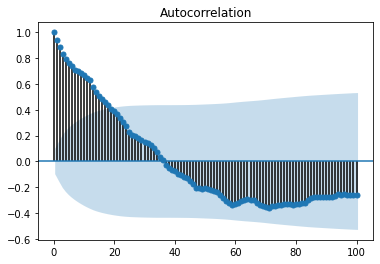

In [ ]:
# Plot of autocorrelation to visually determine p for AR(p) model
# expects a sharp decay for stationary time series
sm.tsa.graphics.plot_acf(hpi_diff[colname].dropna(), lags=100)
plt.show()

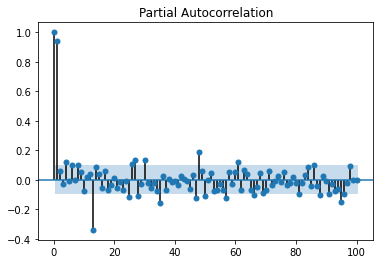

In [ ]:
# Plot of partial autocorrelation to visually determine q for MA(q) model
sm.tsa.graphics.plot_pacf(hpi_diff[colname].dropna(), lags=100)
plt.show()

To determine the lag order, the order of integration, and the order of moving average, the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) are plotted. Since ACF shows a tapering pattern and PACF shows a cut after 1 lag period, p = 1 and q = 1 is a reasonable starting point for the analysis.

In [ ]:
# Mute ARIMA warning: set index frequency = month (as inferred)
hpi_diff.index.freq = hpi_diff.index.inferred_freq

# Fit SARIMA(1,1,1) model
hpi_diff = hpi_diff.dropna()
testsize = int(len(hpi_diff) * 0.9)
train, test = hpi_diff.iloc[:testsize], hpi_diff.iloc[testsize:]

colname = 'log'
model = sm.tsa.statespace.SARIMAX(
    endog=train[colname],
    order=(1,1,1), seasonal_order=(1,1,1,12), start_params=(1,0,0,1),
    enforce_invertibility=False, enforce_stationarity=True
).fit(maxiter=5000, method='nm')
model.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Optimization terminated successfully.
         Current function value: -4.699937
         Iterations: 411
         Function evaluations: 742


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                log   No. Observations:                  348
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1635.578
Date:                            Fri, 26 Jun 2020   AIC                          -3261.156
Time:                                    00:47:28   BIC                          -3242.085
Sample:                                01-01-1988   HQIC                         -3253.553
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0048   3.19e-05    150.805      0.000       0.005       0.005
ma.L1         13.4792   1.07e-07   1.25e+08      0.000      13.479      13.479
ar.S.L12      -0.0979      0.005    -19.382      0.000      -0.108      -0.088
ma.S.L12      -0.7962      0.014    -54.943      0.000      -0.825      -0.768
sigma2       1.77e-08   5.08e-10     34.857      0.000    1.67e-08    1.87e-08
===================================================================================
Ljung-Box (Q):                       81.02   Jarque-Bera (JB):              2299.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.50   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+32. Standard errors may be unstable.
"""

In [ ]:
model.mle_retvals

{'fopt': -4.699936792455449,
 'iterations': 411,
 'fcalls': 742,
 'warnflag': 0,
 'converged': True}

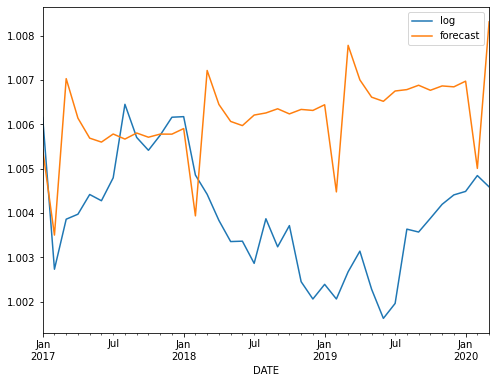

In [ ]:
# Use model to predict trend and compare to test data
if False:
    # use predict(): time as parameter
    np.exp(
        test[[colname]].assign(forecast=model.predict(start=test.index[0], end=test.index[-1]))
    ).plot(figsize=(8,6))
else:
    # use forecast(): number of periods as paramter
    np.exp(
        test[[colname]].assign(forecast=model.forecast(steps=len(test.index)))
    ).plot(figsize=(8,6))
    # If using sm.tsa.arima.ARIMA, model forecast has SE and CI
    # forecast, se, ci = model.forecast(steps=len(test.index), alpha=5)

In [ ]:
# Grid search optimal parameter for ARIMA model
s = 12    # we know the seasonal order is 12

aics = []
for p, d, q in itertools.product([0,1,2,3,4], [0,1,2], [0,1,2,3,4]):
    try:
        model = sm.tsa.statespace.SARIMAX(
            endog=train[colname],
            order=(p,d,q), seasonal_order=(1,1,1,s), start_params=(1,0,0,1),
            enforce_invertibility=False, enforce_stationarity=True
        ).fit(maxiter=5000, method='nm')
        if model.mle_retvals['converged']:
            aics.append((p, d, q, model.aic, model.bic, model.hqic))
    except:
        pass
aics = pd.DataFrame(aics, columns=["p", "d", "q", "aic", "bic", "hqic"])

Optimization terminated successfully.
         Current function value: -3.921399
         Iterations: 153
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: -4.224954
         Iterations: 119
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: -4.526746
         Iterations: 224
         Function evaluations: 388
Optimization terminated successfully.
         Current function value: -4.557043
         Iterations: 262
         Function evaluations: 425
Optimization terminated successfully.
         Current function value: -4.612837
         Iterations: 343
         Function evaluations: 562
Optimization terminated successfully.
         Current function value: -4.731979
         Iterations: 71
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -4.731903
         Iterations: 109
         Function evaluations: 199
Optimization t

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Optimization terminated successfully.
         Current function value: -4.699937
         Iterations: 411
         Function evaluations: 742
Optimization terminated successfully.
         Current function value: -4.732517
         Iterations: 302
         Function evaluations: 505
Optimization terminated successfully.
         Current function value: -4.747325
         Iterations: 268
         Function evaluations: 434
Optimization terminated successfully.
         Current function value: -4.740002
         Iterations: 1639
         Function evaluations: 2621
Optimization terminated successfully.
         Current function value: -4.523258
         Iterations: 127
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -4.702479
         Iterations: 191
         Function evaluations: 327
Optimization terminated successfully.
         Current function value: -4.703327
         Iterations: 374
         Function evaluations: 618
Optimizatio

In [ ]:
aics

,p,d,q,aic,bic,hqic
0,0,0,0,-2723.293610,-2711.842276,-2718.728787
1,0,0,1,-2932.568044,-2917.299599,-2926.481614
2,0,0,2,-3140.615461,-3121.529905,-3133.007424
3,0,0,3,-3159.702166,-3136.799499,-3150.572521
4,0,0,4,-3196.534229,-3169.814451,-3185.882976
...,...,...,...,...,...,...
70,4,2,0,-3197.427081,-3170.749094,-3186.790204
71,4,2,1,-3250.462153,-3219.973025,-3238.305722
72,4,2,2,-3248.313633,-3214.013364,-3234.637648
73,4,2,3,-3248.875357,-3210.763947,-3233.679819


In [ ]:
print("AICs:\n{}".format(aics.pivot_table(index=["d","p"], columns="q", values="aic").to_string()))
print()
print("BICs:\n{}".format(aics.pivot_table(index=["d","p"], columns="q", values="bic").to_string()))
print()
print("HQICs:\n{}".format(aics.pivot_table(index=["d","p"], columns="q", values="hqic").to_string()))

AICs:
q              0            1            2            3            4
d p                                                                 
0 0 -2723.293610 -2932.568044 -3140.615461 -3159.702166 -3196.534229
  1 -3306.529330 -3305.175196 -3303.990615 -3309.007278 -3307.053588
  2 -3305.230117 -3200.196547 -3305.750068 -3243.578282 -3259.424413
  3 -3303.556796 -3301.443034 -3301.198022 -3295.562151 -3194.656216
  4 -3308.996331 -3261.385940 -3252.271176 -3237.454148 -3199.365588
1 0 -3287.457347 -3285.404563 -3283.215627 -3291.733993 -3289.294649
  1 -3285.470485 -3261.156008 -3281.832169 -3290.138519 -3283.041658
  2 -3283.536732 -3280.664903 -3285.817563 -3291.874370 -3284.146392
  3 -3291.881190 -3288.064610 -3290.982853 -3289.575086 -3262.831753
  4 -3288.459072 -3287.144972 -3273.532509 -3287.256232 -3281.266795
2 0 -3052.284714 -3265.358236 -3263.193072 -3260.668596 -3270.201461
  1 -3140.187224 -3262.925654 -3261.515907 -3259.623348 -3268.539583
  2 -3153.353707 -3261.41683

In [ ]:
p, d, q, _, _, hqic = aics.iloc[aics["hqic"].argmin()]
print("Best result: p={}, d={}, q={}, hqic={}".format(p, d, q, hqic))

p, d, q, _, bic, _ = aics.iloc[aics["bic"].argmin()]
print("Best result: p={}, d={}, q={}, bic={}".format(p, d, q, bic))

p, d, q, aic, _, _ = aics.iloc[aics["aic"].argmin()]
print("Best result: p={}, d={}, q={}, aic={}".format(p, d, q, aic))

Best result: p=1.0, d=0.0, q=0.0, hqic=-3300.4428997139935
Best result: p=1.0, d=0.0, q=0.0, bic=-3291.260885268111
Best result: p=1.0, d=0.0, q=3.0, aic=-3309.007278146921


Optimization terminated successfully.
         Current function value: -4.774436
         Iterations: 627
         Function evaluations: 963


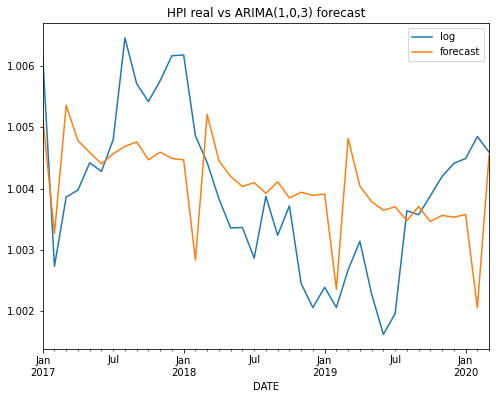

In [ ]:
colname = 'log'
model = sm.tsa.statespace.SARIMAX(
    endog=train[colname],
    order=(p,d,q), seasonal_order=(1,1,1,s), start_params=(1,0,0,1),
    enforce_invertibility=False, enforce_stationarity=True
).fit(maxiter=5000, method='nm')
model.summary()

# Use model to predict trend and compare to test data
forecast = model.forecast(steps=len(test.index))
np.exp(
    test[[colname]].assign(forecast=forecast)
).plot(figsize=(8,6), title="HPI real vs ARIMA(%d,%d,%d) forecast"%(p,d,q))

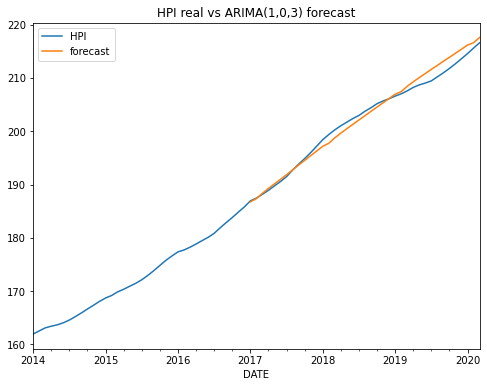

In [ ]:
# Plotting HPI and forecast, from 2014 onward
hpi_diff.join(pd.DataFrame({"forecast":np.exp(forecast.cumsum()) * train.iloc[-1]["HPI"]})) \
        .filter(["HPI", "forecast"]) \
        .loc['2014-01-01':] \
        .plot(figsize=(8,6), title="HPI real vs ARIMA(%d,%d,%d) forecast"%(p,d,q))

Since there is a 12-month seasonality, a modified ARIMA model - the SARIMAX - is used. The SARIMAX(1,1,1) model is trained and fitted using the log return as the underlying time series. The forecast, it turns out, does not fit the observed trend very well. The model’s Akaike Information Criteria (AIC) is −3261.2. The solution space of p, d and q SARIMAX values is searched while using AIC, Bayesian Information Criterion (BIC) and Hannan-Quinn Information Criterion (HQIC) as the fitness functions. After extensive testing, SARIMAX(p = 1, d = 0, q = 3) with an AIC of −3309 is chosen.

The trained model does forecast the HPI well but not the log return. The use of more data for training is usually effective. Moreover, the use of exogenous variables that have explanatory power will probably improve the forecast results. Some of these target variables are GDP growth, mortgage data and disposable income data. The explanatory variables that have a positive correlation with the explained variable ensure good results.